In [1]:
#현재 수준에서 진행이 안되는 것으로 확인, diff(닭고기 소고기 쇠고기 구분 못함)나 kolnpy 수준에서 단순 대조만 가능 

In [2]:
import pandas as pd
import re
df_allergy = pd.read_csv('data/0515.csv')
df_allergy

,Unnamed: 0,rnum,rawmtrl,allergy
0,0,1,"찹쌀,김,참깨,옥수수기름(옥배유),양파,무,대파,천일염,마늘,새우,멸치,다시마,건표...",없음
1,1,2,"찹쌀,김,참깨,옥수수기름(옥배유),아몬드,양파,무,천일염,대파,마늘,새우,멸치,다시...",아몬드
2,2,3,"찹쌀,김,참깨,옥수수기름(옥배유),양파,무,대파,천일염,마늘,새우,멸치,다시마,건표...",없음
3,3,4,군고구마,없음
4,4,5,군고구마,없음
...,...,...,...,...
15087,15087,15088,"된장63.15%[대두{수입산(미국산,중국산,캐나다산)},소맥분(밀:미국산,호주산),...","대두,밀"
15088,15088,15089,"물엿,소맥분(밀:미국산,호주산),혼합양념(중국산)[고춧가루6.12%,(고추:중국산)...",밀
15089,15089,15090,"탈지대두[수입산(인도산,미국산,중국산)],정제수,양조간장원액(대만산)[탈지대두,소맥...","대두,밀"
15090,15090,15091,"정제수,아미노산액[탈지대두:외국산(인도산,미국산,중국산등)],정제소금(국산),액상과...","대두,밀"


In [3]:
from soynlp.normalizer import *
import re

def preprocessing(text):
    # 문제를 일으킬 수 있는 문자 제거
    bad_chars = {"\u200b": "", "…": " ... ", "\ufeff": ""}
    for bad_char in bad_chars:
        text = text.replace(bad_char, bad_chars[bad_char])
        
    error_chars = {"\u3000": " ", "\u2009": " ", "\u2002": " ", "\xa0":" "}
    for error_char in error_chars:
        text = text.replace(error_char, error_chars[error_char])
    
    # ~산 제거 (아황산 제외)
    text = re.sub(r'\b(?!아황산)\w+산\b', '', text).strip()

    # 이메일 제거
    text = re.sub(r"[a-zA-Z0-9+-_.]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+", "[이메일]", text).strip()
    
    # "#문자" 형식 어절 제거
    text = re.sub(r"#\S+", "", text).strip()
    
    # "@문자" 형식 어절 제거
    text = re.sub(r"@\w+", "", text).strip()
    
    # URL 제거
    text = re.sub(r"(http|https)?:\/\/\S+\b|www\.(\w+\.)+\S*", "[웹주소]", text).strip()
    text = re.sub(r"pic\.(\w+\.)+\S*", "[웹주소]", text).strip()
    
    # 뉴스 저작권 관련 텍스트 제거
    re_patterns = [
        r"\<저작권자(\(c\)|ⓒ|©|\(Copyright\)|(\(c\))|(\(C\))).+?\>",
        r"저작권자\(c\)|ⓒ|©|(Copyright)|(\(c\))|(\(C\))"
    ]
    
    for re_pattern in re_patterns:
        text = re.sub(re_pattern, "", text).strip()
    
    # 뉴스 내 포함된 이미지에 대한 레이블 제거
    text = re.sub(r"\(출처 ?= ?.+\) |\(사진 ?= ?.+\) |\(자료 ?= ?.+\)| \(자료사진\) |사진=.+기자 ", "", text).strip()
    
    # 중복 문자 처리
    text = repeat_normalize(text, num_repeats=2).strip()
    
    # 문제를 일으킬 수 있는 구두점 치환
    punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }
    for p in punct_mapping:
        text = text.replace(p, punct_mapping[p])
    
    # 연속된 공백 치환
    text = re.sub(r"\s+", " ", text).strip()
    
    # 개행 문자 "\n" 제거
    text = text.replace('\n', '')
    
    # 영어 제거
    text = re.sub(r'[a-zA-Z]', '', text)
    return text

In [4]:
# def remove_useless_breacket_l(texts):
#     """
#     위키피디아 전처리를 위한 함수입니다.
#     괄호 내부에 의미가 없는 정보를 제거합니다.
#     아무런 정보를 포함하고 있지 않다면, 괄호를 통채로 제거합니다.
#     ``수학(,)`` -> ``수학``
#     ``수학(數學,) -> ``수학(數學)``
#     """
#     bracket_pattern = re.compile(r"\((.*?)\)")
#     preprocessed_text = []
#     for text in texts:
#         modi_text = ""
#         text = text.replace("()", "")  # 수학() -> 수학
#         brackets = bracket_pattern.search(text)
#         if not brackets:
#             if text:
#                 preprocessed_text.append(text)
#                 continue
#         replace_brackets = {}
#         # key: 원본 문장에서 고쳐야하는 index, value: 고쳐져야 하는 값
#         # e.g. {'2,8': '(數學)','34,37': ''}
#         while brackets:
#             index_key = str(brackets.start()) + "," + str(brackets.end())
#             bracket = text[brackets.start() + 1 : brackets.end() - 1]
#             infos = bracket.split(",")
#             modi_infos = []
#             for info in infos:
#                 info = info.strip()
#                 if len(info) > 0:
#                     modi_infos.append(info)
#             if len(modi_infos) > 0:
#                 replace_brackets[index_key] = "(" + ", ".join(modi_infos) + ")"
#             else:
#                 replace_brackets[index_key] = ""
#             brackets = bracket_pattern.search(text, brackets.start() + 1)
#         end_index = 0
#         for index_key in replace_brackets.keys():
#             start_index = int(index_key.split(",")[0])
#             modi_text += text[end_index:start_index]
#             modi_text += replace_brackets[index_key]
#             end_index = int(index_key.split(",")[1])
#         modi_text += text[end_index:]
#         modi_text = modi_text.strip()
#         if modi_text:
#             preprocessed_text.append(modi_text)
#     return preprocessed_text


In [5]:
import re

def remove_useless_breacket(text):
    """
    위키피디아 전처리를 위한 함수입니다.
    괄호 내부에 의미가 없는 정보를 제거합니다.
    아무런 정보를 포함하고 있지 않다면, 괄호를 통채로 제거합니다.
    ``수학(,)`` -> ``수학``
    ``수학(數學,) -> ``수학(數學)``
    """
    bracket_pattern = re.compile(r"\((.*?)\)|\[(.*?)\]|\{(.*?)\}")
    modi_text = ""
    text = text.replace("()", "")  # 수학() -> 수학
    brackets = bracket_pattern.search(text)
    if not brackets:
        if text:
            return text
    replace_brackets = {}
    # key: 원본 문장에서 고쳐야하는 index, value: 고쳐져야 하는 값
    # e.g. {'2,8': '(數學)','34,37': ''}
    while brackets:
        index_key = str(brackets.start()) + "," + str(brackets.end())
        bracket = brackets.group(0)[1:-1]
        infos = bracket.split(",")
        modi_infos = []
        for info in infos:
            info = info.strip()
            if len(info) > 0:
                modi_infos.append(info)
        if len(modi_infos) > 0:
            replace_brackets[index_key] = "(" + ", ".join(modi_infos) + ")"
        else:
            replace_brackets[index_key] = ""
        brackets = bracket_pattern.search(text, brackets.start() + 1)
    end_index = 0
    for index_key in replace_brackets.keys():
        start_index = int(index_key.split(",")[0])
        modi_text += text[end_index:start_index]
        if replace_brackets[index_key] and (not modi_text or modi_text[-1] != ","):
            modi_text += ","
        modi_text += replace_brackets[index_key]
        end_index = int(index_key.split(",")[1])
    modi_text += text[end_index:]
    modi_text = modi_text.strip()
    return modi_text

# 텍스트 스트링을 함수에 적용하여 수정
text = "파이썬(,)은(는) [데이터 분석]{data analysis} {머신 러닝}(machine learning) {} [] 프로그래밍 언어입니다."
modified_text = remove_useless_breacket(text)
print(modified_text)


파이썬은,(는) ,(데이터 분석),(data analysis) ,(머신 러닝),(machine learning)   프로그래밍 언어입니다.


In [6]:
def remove_bad_char(texts):
    bad_chars = {"\u200b": "", "…": " ... ", "\ufeff": ""}
    preprocessed_text  = []
    for text in texts:
        for bad_char in bad_chars:
            text = text.replace(bad_char, bad_chars[bad_char])
        text = re.sub(r"[+á?\xc3\xa1]", "", text)
        if text:
            preprocessed_text.append(text)
    return preprocessed_text

In [7]:
def remove_email(texts):
    preprocessed_text  = []
    for text in texts:
        text = re.sub(r"[a-zA-Z0-9+-_.]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+", "", text).strip()
        if text:
            preprocessed_text.append(text)
    return preprocessed_text

In [8]:
def remove_numbers(text):
    # 정규표현식을 사용하여 숫자를 제거합니다
    cleaned_text = re.sub(r'\d+', '', text)
    return cleaned_text

In [9]:
def remove_hashtag(texts):
    preprocessed_text  = []
    for text in texts:
        text = re.sub(r"#\S+", "", text).strip()
        if text:
            preprocessed_text.append(text)
    return preprocessed_text

In [10]:
def clean_punc(texts):
    punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }
    preprocessed_text  = []
    for text in texts:
        for p in punct_mapping:
            text = text.replace(p, punct_mapping[p])
        text = text.strip()
        if text:
            preprocessed_text.append(text)
    return preprocessed_text

In [11]:
def clean_text(text):
    # 문자열에서 %, /, \, :를 제거합니다
    cleaned_text = text.replace('<', '').replace('>', '').replace('【', '').replace('】', '').replace('^', '').replace('%', '').replace('/', '').replace('\\', '').replace(':', '').replace(';', '').replace('*', '').replace('-', '').replace('등급', '').replace('이상', '').replace('미국', '').replace('호주', '').replace('베트남', '').replace('프랑스', '').replace('독일', '').replace('아르헨티나', '').replace('일본', '').replace('중국', '').replace('캐나다', '').replace('러시아', '').replace('말레이시아', '').replace('칠레', '').replace('브라질', '').replace('인도네시아', '').replace('인도', '').replace('담양', '').replace('소고기', '쇠고기').replace('오스트리아', '').replace('터키', '').replace('콜롬비아', '').replace('º', '').replace('세균수기준', '').replace('우크라이나',"").replace("싱가포르","").replace("네덜란드","")
    # 문자열에서 .을 ,로 바꿉니다
    cleaned_text = cleaned_text.replace('.', ',')
    return cleaned_text

In [12]:
def add_spaces(text):
    # 정규표현식을 사용하여 특수문자 앞뒤에 공백을 추가합니다
    cleaned_text = re.sub(r'([,.\(\)\[\]{}/\\:;%*])', r' \1 ', text)
    return cleaned_text

In [13]:
import re

def replace_brackets(text):
    # 괄호 및 문장 내 공백을 , 로 변경
    text = re.sub(r"[()\[\]{}]", ",", text)
    # 문장 내 공백 제거
    text = text.replace(" ", "")
    # 중복된 , 를 1개로 변경
    text = re.sub(r",+", ", ", text)
        
    return text

# 텍스트 스트링을 함수에 적용하여 수정
text = "파이썬(,)은(는) [데이터 분석]{data analysis} {머신 러닝}(machine learning) 프로그래밍 언어입니다."
modified_text = replace_brackets(text)
print(modified_text)

파이썬, 은, 는, 데이터분석, dataanalysis, 머신러닝, machinelearning, 프로그래밍언어입니다.


In [14]:
def remove_duplicates(text):
    # 문장을 단어로 분할하여 리스트로 저장
    words = text.split(", ")
    
    # 중복된 단어를 제거하여 새로운 리스트 생성
    unique_words = list(set(words))
    
    # 단어들을 다시 ', '로 구분하여 하나의 문자열로 반환
    modified_text = ", ".join(unique_words)

    # 문장의 제일 앞에 있는 ', '를 제거
    modified_text = modified_text.lstrip(", ")
    
    return modified_text

# 텍스트 스트링을 함수에 적용하여 수정
text = "apple, banana, cherry, apple, durian, cherry"
modified_text = remove_duplicates(text)
print(modified_text)

cherry, apple, durian, banana


In [15]:
import re

def remove_words_with_suffix(text, suffix):
    pattern = r'\b\w+' + suffix + r'\b'
    result = re.sub(pattern, '', text)
    return result.strip()

# 예시 텍스트
text = "사과, 배, 딸기, 바나나, 오렌지, 수박등, 복숭아등, 포도, 체리등"

# '등'으로 끝나는 단어 제거 적용
modified_text = remove_words_with_suffix(text, "등")

print(modified_text)

사과, 배, 딸기, 바나나, 오렌지, , , 포도,


In [16]:

def remove_pattern_words(text):
    patterns = ['국가', '홈페이지', '별도', '표기','※','특정','성분','성분명','및','함량']
    result = []
    
    words = text.split(',')
    for word in words:
        word = word.strip()  # 단어 앞뒤 공백 제거
        
        # 패턴 단어 포함 여부 확인
        if not any(pattern in word for pattern in patterns):
            result.append(word)
    
    result_text = ', '.join(result)
    return result_text

In [17]:
#df_allergy['rawmtrl_list'] = 
df_allergy['rawmtrl'][0]

'찹쌀,김,참깨,옥수수기름(옥배유),양파,무,대파,천일염,마늘,새우,멸치,다시마,건표고버섯,둥굴레,감초,정제수'

In [18]:
df_allergy['preprocessing'] = df_allergy['rawmtrl'].apply(add_spaces).apply(remove_numbers).apply(remove_pattern_words).apply(preprocessing).apply(clean_text).apply(lambda x: remove_words_with_suffix(x, '등')).apply(remove_useless_breacket).apply(replace_brackets).apply(remove_duplicates).apply(replace_brackets)


In [19]:
df_allergy.sample(10) #12547
#df_allergy['preprocessing'][13907]#

,Unnamed: 0,rnum,rawmtrl,allergy,preprocessing
9660,9660,9661,"돌김(국산)45.2%,카놀라유(수입산),들기름(들깨:중국산)9.9%,맛소금[정제소금...",알수없음,"참기름, 허브추출물, 맛소금, 돌김, 들기름, 글루타민산나트륨, 정제소금, 들깨, ..."
5631,5631,5632,"쌀99%(국산),정제염,주정",알수없음,"쌀, 정제염, 주정"
4852,4852,4853,"조미명태100%(건조명태살(러시아)89.2%,짝태용조미소스10.8%[정제수,백설탕,...","대두,밀,쇠고기","콩기름, 혼합간장, 합성감미료, 글루타민산나트륨, 후추가루, 과당, 미향, 건양파분..."
5732,5732,5733,닭고기(닭다리/국내산)100%,닭고기,"닭다리, 닭고기"
13249,13249,13250,"혼합귀리분41%(호주산:귀리분80%,설탕,밀브랜(밀),정제소금,중탄산나트륨),설탕,...",알수없음,"혼합귀리분, 밀, 옥수수벌꿀, 귀리분, 중탄산나트륨, 정제소금, 설탕, 밀브랜"
9939,9939,9940,"닭고기75.06%(국산),정백당,전분(수입산),숯불치킨맛시즈닝S.W(밀)3.50%,...",알수없음,"계란, 숯불치킨맛시즈닝, 산도조절제, 간장, 미트프로엠, 정제수, 숯불갈비양념, 함..."
14878,14878,14879,"식물성크림분[물엿,야자유(수입산),카제인나트륨(우유),제2인산칼륨,글리세린지방산에스...",알수없음,"글리세린지방산에스테르, 유청분말, 합성착향료, 덱스트린, 이산화규소, 유청단백분말,..."
12015,12015,12016,"닭가슴살(국산),채소상탕[무(국산),양파(국산),당근,대파,양배추,쌈배추,다시마,청...","닭고기, 계란, 대두, 밀, 호두","다시마, 청경채, 계란, 당근, 팽이버섯, 후추가루, 포도씨유, 호두, 무, 황, ..."
4209,4209,4210,"박력분(밀:미국산,호주산),백설탕,마가린[팜올레인유(말레이시아산),가공유지{팜스테아...",알수없음,"자연치즈, 계란, 치자황색소, 해바라기유, 덱스트린, 팜스테아린유대두유, 팜스테아린..."
14653,14653,14654,"정제수, 물엿, 고추장[물엿, 혼합양념(중국산), 소맥분(밀:미국산, 호주산), 밀...",알수없음,"소맥분, 주정, 글루타민산나트륨, 고추분, 쇠고기다시, 글루타민산나트륨제제, 정제수..."


s

In [20]:
# allergy_dict 미리 정의
allergy_dict = {1: ['알류', '계란', '달걀', '난류','메추리알','추리알','난각','날류','난백','난황','난각','게란','전란','흰자','노른자'], 
                2: ['우유','유우', '탈지분유','유유','분유','유청','카제인','우류','가공버터','유크림','크림','유청','치즈','원유', '요구르트', '요거트','유당','아이스크림','연유','농축유' ], 
                3: ['메밀'], 
                4: ['땅콩', '탕콩', '피넛'],
                5: ['대두','두부','콩','유부','된장','대두유','대두단백','레시틴'], 
                6: ['밀','밀가루','소맥','소맥분', '밀제품'], 
                7: ['고등어'], 
                8: ['게'], 
                9: ['새우'], 
                10: ['돼지','돈','돼지고기','괘지','괘지고기','돼고기','돈창', '돈혈', '돈지방','괘','젤라틴','돈육','순대'],
                11: ['복숭아','황도','백도','천도'], 
                12: ['토마토', '토마투','토마도','토마','토미토'],
                13: ['아황산', '아황산나트륨', '이황산', '이산화', '아산화', '이산화황','아산화황','이산화항','이황산류'],
                14: ['호두','호도','월넛'], 
                15: ['닭', '닭고기', '계육','닭괴','치킨','닭다리', '닭정육', '계정육', '닭가슴살', '닭안심'], 
                16: ['쇠고기', '우육', '소고기', '소뼈','쇠구기', '한우', '우정육', '소정육','소뼈','소잡뼈','우골','소갈비','소내장','소창자','우지','소기름','소안심','소등심', '사골'], 
                17: ['오징어'],
                18: ['조개류','굴','홍합','조개','백합','바지락','전복'], 
                19: ['잣'],
                #20: ['아몬드','헤이즐넛','참깨','피칸'],
                #21: ['페닐알라닌']
                }

# allergy_dict의 모든 값을 '|'로 연결하여 정규식 패턴을 만듭니다.
pattern = '|'.join(sum(allergy_dict.values(), []))

# df['rawmtrl']의 문자열에서 pattern과 일치하는 부분을 찾습니다.
# 결과는 True/False 값을 가지는 데이터프레임 형태로 반환됩니다.
matches = df_allergy['preprocessing'].str.contains(pattern, flags=re.IGNORECASE, regex=True)

# 결과를 저장할 빈 리스트를 만듭니다.
result = [[] for _ in range(len(df_allergy))]

# matches 데이터프레임의 각 행에 대해서
for i, row in matches.iteritems():
    # True인 경우
    if row:
        # 해당 행의 rawmtrl 문자열에서 pattern과 일치하는 모든 단어를 찾아서
        # 그 결과를 리스트로 만듭니다.
        words = re.findall(pattern, df_allergy.at[i, 'preprocessing'], flags=re.IGNORECASE)
        
        # 각 단어에 대해서
        for word in words:
            # allergy_dict에서 해당 단어를 포함하는 키를 찾아서
            for key, values in allergy_dict.items():
                if word.lower() in [v.lower() for v in values]:
                    # 해당 키를 result 리스트에 추가합니다.
                    result[i].append(key)

# 결과 리스트에서 중복된 값을 제거합니다.
result = [list(set(r)) for r in result]

# 결과를 새로운 칼럼으로 추가합니다.
df_allergy['allergens_num'] = result

In [21]:
# 결과를 저장할 리스트를 생성합니다.
result = []

# matches 데이터프레임의 각 행에 대해서
for i, row in matches.iteritems():
    # True인 경우
    if row:
        # 해당 행의 rawmtrl 문자열에서 pattern과 일치하는 모든 단어를 찾아서
        # 그 결과를 리스트로 만듭니다.
        words = re.findall(pattern, df_allergy.at[i, 'preprocessing'], flags=re.IGNORECASE)
        
        # 해당하는 인덱스에 1을 저장하는 리스트를 생성합니다.
        allergens = [0] * len(allergy_dict)
        
        # 각 단어에 대해서
        for word in words:
            # allergy_dict에서 해당 단어를 포함하는 키를 찾아서
            for key, values in allergy_dict.items():
                if word.lower() in [v.lower() for v in values]:
                    # 해당하는 인덱스에 1을 저장합니다.
                    allergens[key-1] = 1
        
        # 결과 리스트에 추가합니다.
        result.append(allergens)
    else:
        # False인 경우에는 모든 요소가 0인 리스트를 추가합니다.
        result.append([0] * len(allergy_dict))

# 결과를 새로운 칼럼으로 추가합니다.
df_allergy['allergens'] = result

In [22]:
# # # 결과를 저장할 리스트를 생성합니다.
# # result = []

# # # matches 데이터프레임의 각 행에 대해서
# # for i, row in matches.iteritems():
# #     # True인 경우
# #     if row:
# #         # 해당 행의 rawmtrl 문자열에서 pattern과 일치하는 모든 단어를 찾아서
# #         # 그 결과를 리스트로 만듭니다.
# #         words = re.findall(pattern, df_allergy.at[i, 'preprocessing'], flags=re.IGNORECASE)
        
# #         # 해당하는 인덱스에 1을 저장하는 리스트를 생성합니다.
# #         allergens = [0] * (len(allergy_dict) + 1)  # 0을 추가하기 위해 리스트의 길이를 1 증가시킵니다.
        
# #         # 각 단어에 대해서
# #         for word in words:
# #             # allergy_dict에서 해당 단어를 포함하는 키를 찾아서
# #             for key, values in allergy_dict.items():
# #                 if word.lower() in [v.lower() for v in values]:
# #                     # 해당하는 인덱스에 1을 저장합니다.
# #                     allergens[key] = 1  # 인덱스를 key로 변경하고, 1을 저장합니다.
        
# #         # 결과 리스트에 추가합니다.
# #         result.append(allergens)
# #     else:
# #         # False인 경우에는 모든 요소가 0인 리스트를 추가합니다.
# #         result.append([0] * (len(allergy_dict) + 1))  # 0을 추가하기 위해 리스트의 길이를 1 증가시킵니다.

# # # 결과를 새로운 칼럼으로 추가합니다.
# # df_allergy['allergens1'] = result
# # 결과를 저장할 리스트를 생성합니다.
# result = []

# # matches 데이터프레임의 각 행에 대해서
# for i, row in matches.iteritems():
#     # True인 경우
#     if row:
#         # 해당 행의 rawmtrl 문자열에서 pattern과 일치하는 모든 단어를 찾아서
#         # 그 결과를 리스트로 만듭니다.
#         words = re.findall(pattern, df_allergy.at[i, 'preprocessing'], flags=re.IGNORECASE)
        
#         # 해당하는 인덱스에 1을 저장하는 리스트를 생성합니다.
#         allergens = [0] * len(allergy_dict)
        
#         # 각 단어에 대해서
#         for word in words:
#             # allergy_dict에서 해당 단어를 포함하는 키를 찾아서
#             for key, values in allergy_dict.items():
#                 if word.lower() in [v.lower() for v in values]:
#                     # 해당하는 인덱스에 1을 저장합니다.
#                     allergens[key-1] = 1
        
#         # 결과 리스트에 추가합니다.
#         result.append(allergens)
#     else:
#         # False인 경우에는 모든 요소가 0인 리스트를 추가합니다.
#         result.append([0] * len(allergy_dict))

# # 결과를 새로운 컬럼으로 추가합니다.
# for i, allergen_key in enumerate(allergy_dict.keys()):
#     column_name = f'allergen_{allergen_key}'
#     df_allergy[column_name] = [row[i] for row in result]


In [23]:
# # 결과를 저장할 리스트를 생성합니다.
# result = []

# # matches 데이터프레임의 각 행에 대해서
# for i, row in matches.iteritems():
#     # True인 경우
#     if row:
#         # 해당 행의 rawmtrl 문자열에서 pattern과 일치하는 모든 단어를 찾아서
#         # 그 결과를 리스트로 만듭니다.
#         words = re.findall(pattern, df_allergy.at[i, 'preprocessing'], flags=re.IGNORECASE)
        
#         # 해당하는 인덱스에 1을 저장하는 리스트를 생성합니다.
#         allergens = [0] * (len(allergy_dict) + 1)  # 0을 추가하기 위해 리스트의 길이를 1 증가시킵니다.
        
#         # 각 단어에 대해서
#         for word in words:
#             # allergy_dict에서 해당 단어를 포함하는 키를 찾아서
#             for key, values in allergy_dict.items():
#                 if word.lower() in [v.lower() for v in values]:
#                     # 해당하는 인덱스에 1을 저장합니다.
#                     allergens[key] = 1  # 인덱스를 key로 변경하고, 1을 저장합니다.
        
#         # 결과 리스트에 추가합니다.
#         result.append(allergens)
#     else:
#         # False인 경우에는 첫 번째 요소를 1로, 나머지 요소를 0으로 갖는 리스트를 추가합니다.
#         allergens = [1] + [0] * len(allergy_dict)  # 첫 번째 요소를 1로, 나머지 요소를 0으로 초기화합니다.
#         result.append(allergens)

# # 결과를 새로운 칼럼으로 추가합니다.
# df_allergy['allergens1'] = result

# 결과를 저장할 리스트를 생성합니다.
result = []

# matches 데이터프레임의 각 행에 대해서
for i, row in matches.iteritems():
    # True인 경우
    if row:
        # 해당 행의 rawmtrl 문자열에서 pattern과 일치하는 모든 단어를 찾아서
        # 그 결과를 리스트로 만듭니다.
        words = re.findall(pattern, df_allergy.at[i, 'preprocessing'], flags=re.IGNORECASE)
        
        # 해당하는 인덱스에 1을 저장하는 리스트를 생성합니다.
        allergens = [0] * (len(allergy_dict) + 1)  # 0을 추가하기 위해 리스트의 길이를 1 증가시킵니다.
        
        # 각 단어에 대해서
        for word in words:
            # allergy_dict에서 해당 단어를 포함하는 키를 찾아서
            for key, values in allergy_dict.items():
                if word.lower() in [v.lower() for v in values]:
                    # 해당하는 인덱스에 1을 저장합니다.
                    allergens[key] = 1  # 인덱스를 key로 변경하고, 1을 저장합니다.
        
        # 결과 리스트에 추가합니다.
        result.append(allergens)
    else:
        # False인 경우에는 모든 요소가 0인 리스트를 추가합니다.
        result.append([0] * (len(allergy_dict) + 1))  # 0을 추가하기 위해 리스트의 길이를 1 증가시킵니다.

# 결과를 새로운 컬럼으로 추가합니다.
for i in range(len(allergy_dict) + 1):
    column_name = f'allergen_{i}'
    df_allergy[column_name] = [row[i] for row in result]

In [ ]:
df_allergy[df_allergy['allergen_19'] == 1]

In [25]:
import numpy as np
df_allergy.columns
# df_allergy.loc[df_allergy['allergens'].apply(lambda x: x == []), 'allergens'] = np.array([[0]])

Index(['Unnamed: 0', 'rnum', 'rawmtrl', 'allergy', 'preprocessing',
       'allergens_num', 'allergens', 'allergen_1', 'allergen_2', 'allergen_3',
       'allergen_4', 'allergen_5', 'allergen_6', 'allergen_7', 'allergen_8',
       'allergen_9', 'allergen_10', 'allergen_11', 'allergen_12',
       'allergen_13', 'allergen_14', 'allergen_15', 'allergen_16',
       'allergen_17', 'allergen_18', 'allergen_19'],
      dtype='object')

In [72]:
data_set = df_allergy.drop(['Unnamed: 0', 'rnum', 'rawmtrl', 'allergy', 'allergens_num', 'allergens'], axis=1)
# data_set.rename(columns={'allergens1': 'label'}, inplace=True)
data_set.head()
y = np.array(data_set.iloc[:,1:])
y = torch.tensor(y, dtype=torch.float)


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [45]:
X = data_set['preprocessing']

In [28]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer
from sklearn.model_selection import train_test_split

MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [73]:
train_data, test_data, train_label, test_label = train_test_split(X, y, test_size=0.2, random_state=42)

7324                 태움용융소금, 밀, 밀가루, 유정란, 말차, 우유, 버터, 갈색설탕
12828    글리세린지방산에스테르, 이산화규소, 탄산마그네슘, 정제수, 탄산칼슘, 비타민, 액상...
5306     락색소, 돼지고기, 파슬리후레이크, 정제수, 혼합제제, 메타인산나트륨, 알파미분, ...
3651     레몬추출분말, 등, 석류추출분말, 카라기난, 로즈마리추출분말, 정제수, 백설탕, 돼...
6000                                                      
                               ...                        
5191     발삼식초, 주정, 타미란드검, 청주, 과당, 양파퓨레, 정제수, 함수결정포도당, 볶...
13418    불갈비양념맛소시지돼지고기, 글루타민산나트륨, 산도조절제, 호스이엔알, 불갈비양념엔,...
5390                                                    들깨
860      인산염, 흑후추분태, 소르비톨, 청양고추농축액, 간장, 프로텍스, 영국, 소르빈산칼...
7270     커피향, 레시틴, 연유, 백설탕, 버터, 우유, 정제소금, 합성착향료, 대두, 인스...
Name: preprocessing, Length: 12073, dtype: object

In [60]:
list(train_data)

['태움용융소금, 밀, 밀가루, 유정란, 말차, 우유, 버터, 갈색설탕',
 '글리세린지방산에스테르, 이산화규소, 탄산마그네슘, 정제수, 탄산칼슘, 비타민, 액상과당, 식물성유지, 자당, 유, 대두고형분, 잔탄검, 드라이비타민, 정제소금, 아라비아검, 채종유, 전분, 티제이, 레시틴, 두유액',
 '락색소, 돼지고기, 파슬리후레이크, 정제수, 혼합제제, 메타인산나트륨, 알파미분, 백설탕, 발색제, 분말난백, 아질산나트륨, 글루탐산나트륨, 카라기난, 캠핑용스파이스, 대두단백, 트랜스글루타미나아제, 쌀, 정제소금, 피로인산나트륨, 폴리인산나트륨, 향미증진제',
 '레몬추출분말, 등, 석류추출분말, 카라기난, 로즈마리추출분말, 정제수, 백설탕, 돼지고기, 과일혼합추출분말, 혼합제제, 정제소금, 스페인, 스페인정제소금, 메타인산나트륨, 피로인산나트륨, 폴리인산나트륨',
 '',
 "어육살, 주정, 글루타민산나트륨, 당근, 소르비톨, 산도조절제, 소스류, 글리신, 고춧가루, 덱스트린, 글루타민산나트륨제제, 잔탄검풍성한어묵탕건더기스프볶은미역, 감자전분, 표고버섯농축액, 기타가공품, 무, 풍성한어묵탕냉동연육, 소맥전분, 풍성한어묵탕액상소스오뎅육수베이스, 소르빈산칼륨, 양송이농축액, 정제수, 글루코노델타락톤, 건조조미새우, 합성보존료, 포고버섯, 대파, 식용유, 혼합제제, 탈지대두, 우지, 설탕, 물엿, 표고버섯엑기스농축액, 정제염, 양조간장, 미작, 식염, 대두유, 떡, 버섯감치미, 변성전분, 백설탕, 제재염, 자일로오스, 글루탐산나트륨, 양파, 건조새우, 향미증진제, 참기름, 오뎅다시, 구운미역칩, 건미역, '리보뉴클레오티드이나트륨, 건고추, 쌀, 정제소금, 식용우지, 링홍고추후레이크, 메추리알, 어육추출액, 발효식초",
 '멥쌀가루, 녹두가루, 볶음쌀가루, 베이킹파우더, 잔탄검, 산도조절제, 정제소금, 전분, 비타민, 녹두, 유화제',
 '소맥분, 어묵맛시즈닝, 소르빈산칼륨, 글루타민산나트륨, 백설탕, 글루코노델타락톤, 당근, 어육, 자일로오스, 소르비톨, 산도조절제,

654
109.72260415803859
전체 샘플 중 길이가 300 이하인 샘플의 비율: 96.83591485132112


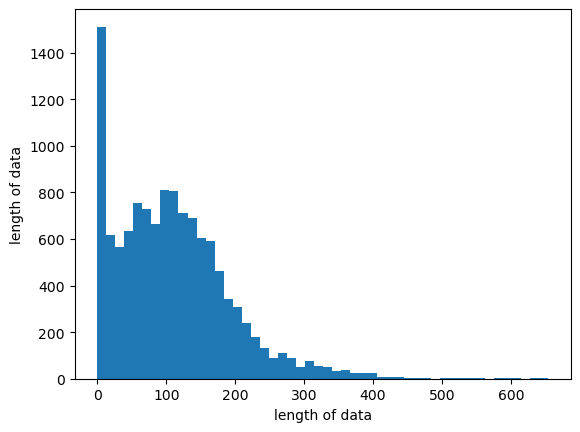

In [34]:
#아웃라이어 삭제

print(max(len(l) for l in train_data['preprocessing'])) #최대길이
print(sum(map(len, train_data['preprocessing']))/len(train_data['preprocessing'])) #평균길이

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 300
below_threshold_len(max_len, train_data['preprocessing'] )

from matplotlib import pyplot as plt
plt.hist([len(s) for s in train_data['preprocessing']], bins=50)
plt.xlabel('length of data')
plt.ylabel('length of data')
plt.show() #너무 길 경우 필터해버림 (토큰 짤라)

In [61]:
tokenized_train_sentences = tokenizer(
      list(train_data),
      return_tensors="pt",
      padding=True,
      truncation=True,
      add_special_tokens=True,
      max_length = max_len
)
print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=300, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '태', '##움', '##용', '##융', '##소', '##금', ',', '밀', ',', '밀', '##가', '##루', ',', '유', '##정', '##란', ',', '말', '##차', ',', '우', '##유', ',', '버', '##터', ',', '갈', '##색', '##설', '##탕', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

In [62]:
tokenized_test_sentences = tokenizer(
      list(test_data),
      return_tensors="pt",
      padding=True,
      truncation=True,
      add_special_tokens=True,
      max_length = max_len
)
print(tokenized_test_sentences[0])
print(tokenized_test_sentences[0].tokens)
print(tokenized_test_sentences[0].ids)
print(tokenized_test_sentences[0].attention_mask)

Encoding(num_tokens=300, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '빵', '##효', '##모', ',', '돼', '##지고', '##기', ',', '조', '##제', '##분', '##유', ',', '산', '##도', '##조', '##절', '##제', ',', '등', '##심', ',', '세', '##르', '##비아', ',', '옥', '##수', '##수', ',', '밀', '##글', '##루', '##텐', ',', '생', '##이스', '##트', ',', '정', '##제', '##수', ',', '메', '##타', '##인', '##산', '##나', '##트', '##륨', ',', '옥', '##수', '##수', '##전', '##분', ',', '강', '##력', '##밀', '##가', '##루', ',', '백', '##설', '##탕', ',', '베', '##타', '##믹', '##스', ',', '박', '##력', '##분', ',', '골', '##드', '##식', '##빵', '##가', '##루', ',', '밀', ',', '마', '##가', '##린', ',', '정', '##제', '##소', '##금', ',', '산', '##서', '##피', '##로', '##인', '##산', '##나', '##트', '##륨', ',', '가', '##공', '##유', '##지', ',', '폴', '##리', '##인', '##산', '##나', '##트', '##륨', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '

In [44]:
# train_label = train_data['label'].values
# test_label = test_data['label'].values

In [63]:
import torch
class SingleSentDataset(torch.utils.data.Dataset):
      def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

      def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

      def __len__(self):
            return len(self.labels)




In [75]:
train_dataset = SingleSentDataset(tokenized_train_sentences, train_label)
test_dataset = SingleSentDataset(tokenized_test_sentences, test_label)

In [65]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=20,problem_type="multi_label_classification")

training_args = TrainingArguments(
    output_dir='/results',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=500, #러닝레이트 (0~맥시멈 갔다가 떨어트리는 식으로 구성)
    weight_decay=0.01,
    logging_dir='/logs',
    logging_steps=500,
    save_steps=500,
    save_total_limit=2
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [67]:
trainer = Trainer(
    model=model,               
    args=training_args,
    train_dataset= train_dataset,
    eval_dataset = test_dataset
)

In [68]:
# !pip install transformer
# !pip install accelerate
# !pip install soynlp

NameError: name 'train' is not defined

In [125]:
model.load_state_dict(torch.load('nlp_model_5epoch.pth', map_location=torch.device('cpu')))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [140]:
def sentences_predict(sent):
    model.eval()
    tokenized_sent = tokenizer(
        sent,
        return_tensors="pt",
        truncation=True,
        add_special_tokens=True,
        max_length=128
    )
    tokenized_sent.to('cpu')

    with torch.no_grad():  # Disable gradient calculation
        outputs = model(
            input_ids=tokenized_sent['input_ids'],
            attention_mask=tokenized_sent['attention_mask'],
            token_type_ids=tokenized_sent['token_type_ids']
        )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # Apply sigmoid to convert logits to probabilities
    return probabilities

probabilities = sentences_predict(df_allergy['preprocessing'][12015])
print(probabilities)


[[0.07566561 0.9447312  0.07946803 0.05829531 0.14245488 0.06437857
  0.02817593 0.11942939 0.12905978 0.07751974 0.01492427 0.07125171
  0.03702423 0.04144526 0.7197831  0.8865845  0.03686175 0.05892391
  0.0729169  0.09336578]]


In [141]:
df_allergy['allergens'][12015]



[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]

In [ ]:
allergy_dict = {1: ['알류', '계란', '달걀', '난류','메추리알','추리알','난각','날류','난백','난황','난각','게란','전란','흰자','노른자'], 
                2: ['우유','유우', '탈지분유','유유','분유','유청','카제인','우류','가공버터','유크림','크림','유청','치즈','원유', '요구르트', '요거트','유당','아이스크림','연유','농축유' ], 
                3: ['메밀'], 
                4: ['땅콩', '탕콩', '피넛'],
                5: ['대두','두부','콩','유부','된장','대두유','대두단백','레시틴'], 
                6: ['밀','밀가루','소맥','소맥분', '밀제품'], 
                7: ['고등어'], 
                8: ['게'], 
                9: ['새우'], 
                10: ['돼지','돈','돼지고기','괘지','괘지고기','돼고기','돈창', '돈혈', '돈지방','괘','젤라틴','돈육','순대'],
                11: ['복숭아','황도','백도','천도'], 
                12: ['토마토', '토마투','토마도','토마','토미토'],
                13: ['아황산', '아황산나트륨', '이황산', '이산화', '아산화', '이산화황','아산화황','이산화항','이황산류'],
                14: ['호두','호도','월넛'], 
                15: ['닭', '닭고기', '계육','닭괴','치킨','닭다리', '닭정육', '계정육', '닭가슴살', '닭안심'], 
                16: ['쇠고기', '우육', '소고기', '소뼈','쇠구기', '한우', '우정육', '소정육','소뼈','소잡뼈','우골','소갈비','소내장','소창자','우지','소기름','소안심','소등심', '사골'], 
                17: ['오징어'],
                18: ['조개류','굴','홍합','조개','백합','바지락','전복'], 
                19: ['잣'],